# Machine Learning Engineer Nanodegree
## Capstone Project
## Esteban Dib

In this project, I will cluster customers from a shoes and bag vendor in Chile. The objective is to be able to know better the customers and to take some business decisions based on the data analyzed.

In [4]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("capstone_processed_data.csv")
except:
    print("Dataset could not be loaded. Is the dataset missing?")

# Remove noise generated while consolidating the data
data.drop(data.columns[[0, 1, 2, 3]],axis=1,inplace=True)
# Remove columns that will not be used in this analysis
data.drop(columns=['date', 'year', 'month', 'rut_v', 'purchase_type', 'address', 'name', 'email', 'store', 'sex', 'category', 'commune'],inplace=True)
# Remove age = 0, which in this case, means people that has a RUT which does not correlate to their age.
data.drop(data[data['age'] == 0].index, inplace=True)
# Remove rows with NA data
data.dropna(inplace=True)

    
# Sum all items purchased and all money spent by each person in the analyzed period
grouped_sum = pd.DataFrame(data.groupby('rut', as_index=False)['quantity', 'total_value'].sum())
grouped_sum.rename(index=str, columns={'quantity': 'period_total_quantity', 'total_value': 'period_total_value'}, inplace=True)


# Remove rut duplicates to get one row per customer
data.drop_duplicates('rut', inplace=True)

# Merge the data with the new generated information
data = data.merge(grouped_sum, 'right', on='rut')

# Drop individual purchase quantities and values
data.drop(columns=['quantity', 'total_value'], inplace=True)

print("Company customers dataset has {} samples with {} features each.".format(*data.shape))


Company customers dataset has 1430 samples with 4 features each.


## Data Exploration
Lets see some aggregated data and the columns available after cleaning the initial data

In [5]:
# Display a description of the dataset
display(data.describe())

,rut,age,period_total_quantity,period_total_value
count,1.430000e+03,1430.000000,1430.000000,1430.000000
mean,1.418642e+07,38.914978,1.942657,32226.166434
std,3.940645e+06,13.634632,2.532269,40632.651669
min,1.100000e+01,12.049076,1.000000,2975.000000
25%,1.136004e+07,27.809814,1.000000,16588.000000
50%,1.517836e+07,35.482873,1.000000,21630.000000
75%,1.739601e+07,48.694251,2.000000,32798.000000
max,2.195113e+07,87.999962,35.000000,544100.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. Below, we see ten indices that we will track.

In [6]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [0, 143, 280, 420, 560, 700, 840, 980, 1120, 1260, 1400]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,rut,age,period_total_quantity,period_total_value
0,15640698,33.883185,12,156234
1,19109490,21.881165,2,18420
2,13111237,42.635120,1,20773
3,16769033,29.979146,2,39807
4,17550321,27.275889,7,104638
5,17842531,26.264843,7,88506
6,9188731,56.206991,2,47597
7,11787115,47.216582,1,12521
8,18972507,22.355126,1,11361
9,10703346,50.966423,1,15076


### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the four features is actually relevant for understanding customer segments. That is to say, is it possible to determine whether a customer's feature such as age, total money spent or amount of items bought can be predicted with the other features? I will train a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, I:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
def get_score(feature):
    new_data = data.copy()
    new_data.drop(feature, axis = 1, inplace = True)

    # TODO: Split the data into training and testing sets(0.25) using the given feature as the target
    # Set a random state.
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[feature], test_size=0.25, random_state=42)

    # TODO: Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)

    # TODO: Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    return score

features = ['age', 'rut', 'period_total_quantity', 'period_total_value']
scores = []
for feature in features:   
    scores.append(get_score(feature))
dictionary = dict(zip(features, scores))
print(dictionary)

{'age': 0.9997344264579751, 'rut': 0.9999700371844167, 'period_total_quantity': 0.4209039828357187, 'period_total_value': 0.5252325423544659}


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


With the function above, we have the R^2 scores for each of the features analyzed

* age: 0.9998970965956567
* rut: 0.9999072321112602
* period_total_quantity: 0.43724656982317694
* period_total_value: 0.5259504252879161

Considering this, I will not use the rut, but I will keep the age. The age was calculated using the rut in the following way: 2018 - rut / 1000000 * 3.46 + 1930, so it is obvious that it has a big R^2. This calculation was done to make the clusters more readable by humans.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the three remaining customer features present in the data.

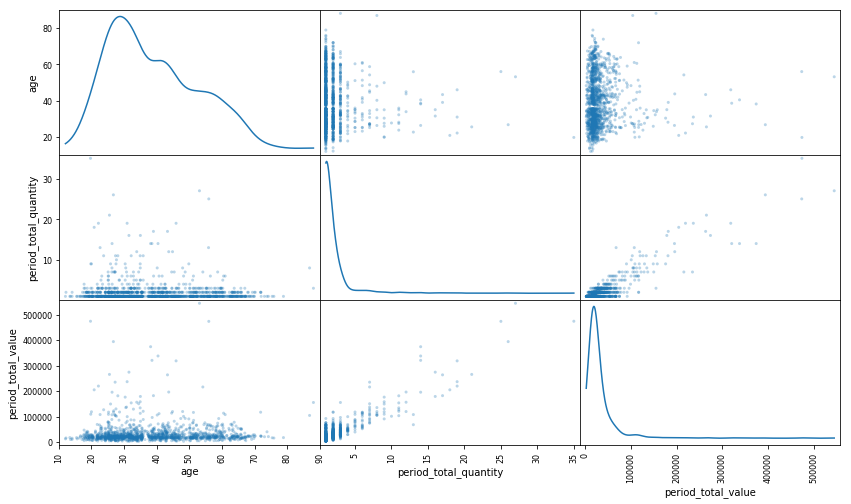

In [8]:
# Drop rut column
data = data.drop(columns=['rut'])
samples = samples.drop(columns=['rut'])

# Produce a scatter matrix for each pair of features in the data (not counting one-hot encoding)
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

We will also use seaborn to see a heatmap and to calculate the correlation between the features

                            age  period_total_quantity  period_total_value
age                    1.000000              -0.050843             0.01109
period_total_quantity -0.050843               1.000000             0.89982
period_total_value     0.011090               0.899820             1.00000


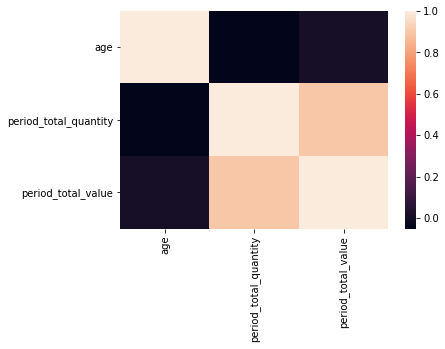

In [9]:
import seaborn
seaborn.heatmap(data.corr())
print(data.corr())

We can see that period_total_value and period_total_quantity are very related, but I will still keep both, because it will be important to determine if a cluster normally buys a lot of cheap products, or not very much expensive products

## Data Preprocessing
In this section, I will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting and removing outliers.

### Feature Scaling
We will apply the natural logarithm to the three features in an attempt to make them more normally distributed


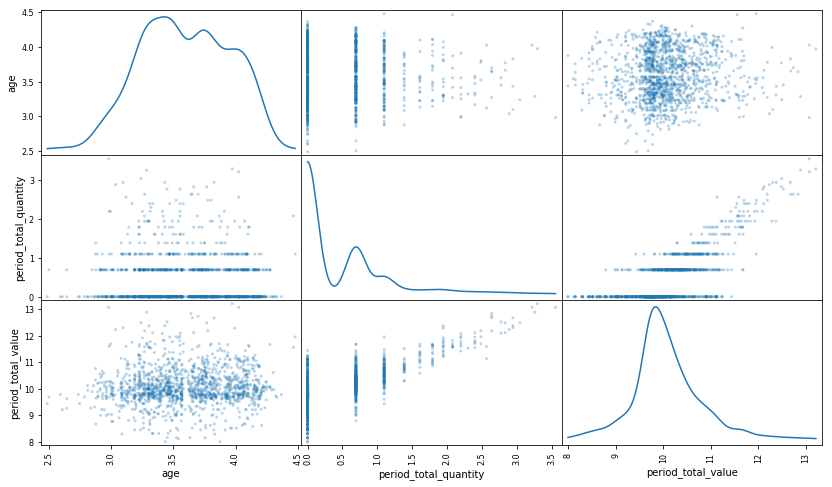

In [10]:
# Scale the data using the natural logarithm
log_data = data.copy()
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = samples.copy()
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


### Outlier Detection

In [11]:
# For each feature find the data points with extreme high or low values
for feature in ['age', 'period_total_quantity', 'period_total_value']:
    
    # Q1 (25th percentile of the data) for the given feature
    Q1 = log_data[feature].quantile(0.25)
    
    # Q3 (75th percentile of the data) for the given feature
    Q3 = log_data[feature].quantile(0.75)

    # Interquartile range
    step = (Q3 - Q1)*1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    # OPTIONAL: Select the indices for data points you wish to remove
    outliers = [1211, 1, 2, 3, 6, 14, 20]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'age':


,age,period_total_quantity,period_total_value


Data points considered outliers for the feature 'period_total_quantity':


,age,period_total_quantity,period_total_value
0,3.522919,2.484907,11.959110
1,4.024494,3.218876,13.067218
2,3.972124,3.295837,13.206888
3,2.982119,3.555348,13.068135
4,3.252939,2.197225,11.913331
5,3.309933,2.397895,11.546960
6,3.037365,2.890372,12.229652
8,3.908753,2.197225,11.416293
9,3.698918,2.639057,12.729184
10,3.492584,1.945910,11.768660


Data points considered outliers for the feature 'period_total_value':


,age,period_total_quantity,period_total_value
0,3.522919,2.484907,11.959110
1,4.024494,3.218876,13.067218
2,3.972124,3.295837,13.206888
3,2.982119,3.555348,13.068135
4,3.252939,2.197225,11.913331
5,3.309933,2.397895,11.546960
6,3.037365,2.890372,12.229652
9,3.698918,2.639057,12.729184
10,3.492584,1.945910,11.768660
12,3.299968,1.945910,11.592984


We have some outliers. I will use the quantity to represent them, and delete those bigger than 2.8: log(period_total_quantity) > 2.8.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone.

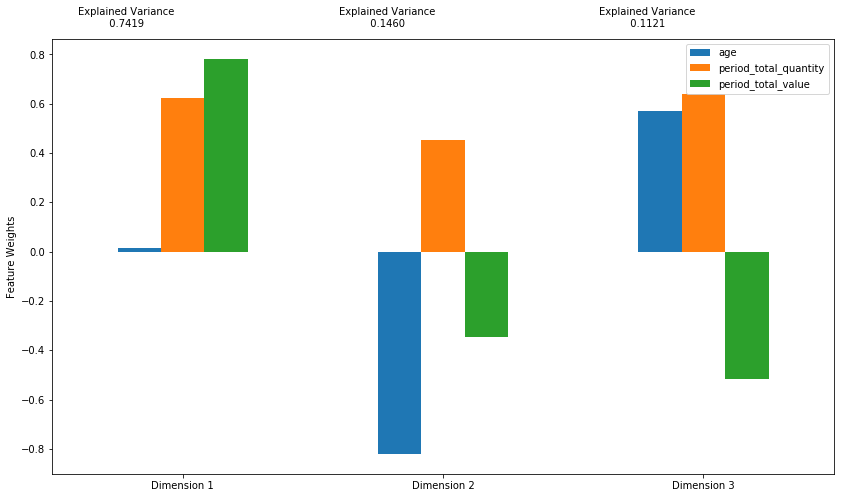

In [12]:
from sklearn.decomposition import PCA
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=3)
pca.fit(good_data)
# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

The total quantity and the total value are giving most of the variance in the dataset, which means that the age of the customer impacts less in the purchase habits

### Observation
We can see how our sample data has changed after applying the PCA

In [13]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3
0,2.7977,0.3639,0.3193
1,0.0033,0.6505,0.0341
2,-0.3249,-0.2534,-0.0891
3,0.6106,0.1249,-0.1850
4,2.1454,0.4362,0.0594
5,2.0139,0.5252,0.1245
6,0.7592,-0.4530,0.0814
7,-0.7195,-0.1618,0.2312
8,-0.8061,0.4857,-0.1453
9,-0.5732,-0.2888,0.1787


### Dimensionality Reduction

Almost 90% of the variance is explained by two dimensions, I will only use those so it is easier to visualize the data.

In [14]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Now we can see how the samples look in 2 dimensions

In [15]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,2.7977,0.3639
1,0.0033,0.6505
2,-0.3249,-0.2534
3,0.6106,0.1249
4,2.1454,0.4362
5,2.0139,0.5252
6,0.7592,-0.4530
7,-0.7195,-0.1618
8,-0.8061,0.4857
9,-0.5732,-0.2888


### Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

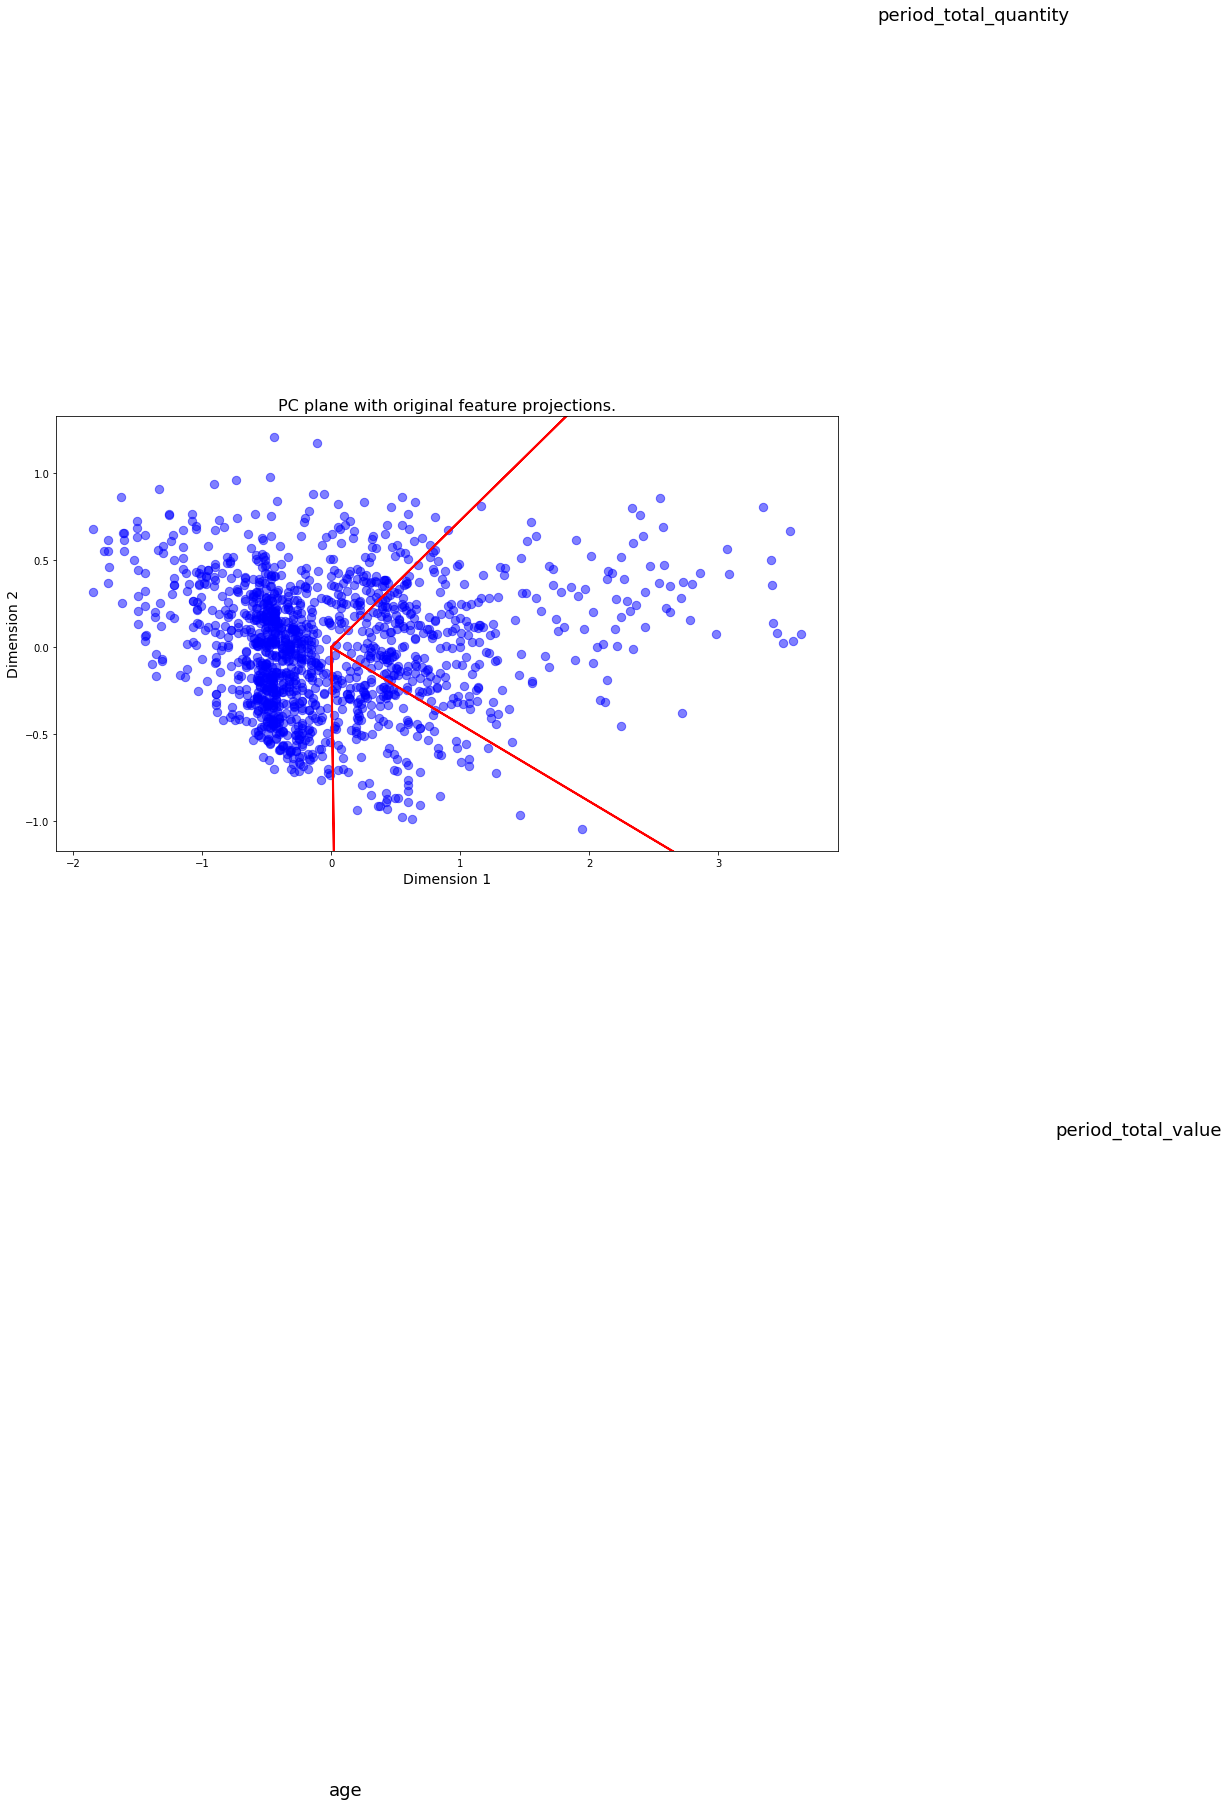

In [16]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. A point far down means more age, and far up less age. A point on the top right corner means that customer has bought lots of products at low prices and a point on the bottom right means that customer has bought less items but at high prices

## Clustering and metrics

In this section, I will use a K-Means clustering to create the benchmark model. I will also use GMM and DBSCAN to cluster the data and compare the three algorithms by using the silhouette score and the Calinski-Harabaz score.

### GMM and K-Means
For each clustering algorithm I will measure the metrics. For GMM and K means I will try different number of components/clusters and choose the best scores possible.

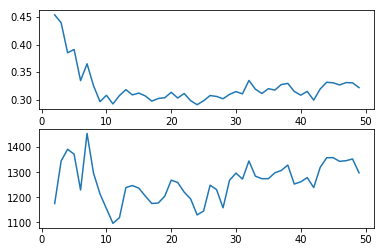

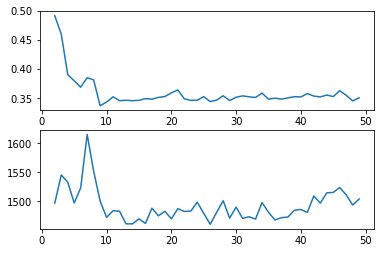

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

gm_s_scores = []
gm_ch_scores = []
km_s_scores = []
km_ch_scores = []
indices = []
for i in range(2, 50):
    indices.append(i)
    
    # Apply Gaussian Mixture Model
    gm = GaussianMixture(n_components=i, random_state=42)
    # Fit the data
    gm_clusterer = gm.fit(reduced_data)

    # Predict the cluster for each data point
    gm_preds = gm_clusterer.predict(reduced_data)

    # Find the cluster centers
    gm_centers = gm_clusterer.means_

    # Predict the cluster for each transformed sample data point
    gm_sample_preds = gm_clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient and calinski-harabaz score for the number of clusters chosen
    gm_s_scores.append(metrics.silhouette_score(reduced_data, gm_preds, random_state=42))
    gm_ch_scores.append(metrics.calinski_harabaz_score(reduced_data, gm_preds))
    
    
    # Apply K-means model
    km = KMeans(n_clusters=i)
    # Fit the data
    km_clusterer = km.fit(reduced_data)

    # Predict the cluster for each data point
    km_preds = km_clusterer.predict(reduced_data)

    # Find the cluster centers
    km_centers = km_clusterer.cluster_centers_

    # Predict the cluster for each transformed sample data point
    km_sample_preds = km_clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient and calinski-harabaz score for the number of clusters chosen
    km_s_scores.append(metrics.silhouette_score(reduced_data, km_preds, random_state=42))
    km_ch_scores.append(metrics.calinski_harabaz_score(reduced_data, km_preds))

plt.figure(1)
plt.subplot(211)
plt.plot(indices, gm_s_scores)

plt.subplot(212)
plt.plot(indices, gm_ch_scores)

plt.show()

plt.figure(2)
plt.subplot(211)
plt.plot(indices, km_s_scores)

plt.subplot(212)
plt.plot(indices, km_ch_scores)
plt.show()




Although the silhoette score decreases as more clusters are inserted, it grows a little at seven clusters. The Calinski-Harabaz score shows this more clearly, showing a peak at seven clusters

### Optimizing the GMM
Now that we now that the best number of clusters is 7, I will use grid search to find the best combinations of hyperparameters for the GMM model.


In [18]:
covariance_values = ['full', 'tied', 'diag', 'spherical']
tol_values = [1e-3, 1e-2, 1e-1, 5e-1]
max_iter_values = [50, 100, 200]
init_params_values = ['kmeans', 'random']

covariance_array = []
tol_array = []
max_iter_array = []
init_params_array = []
s_array = []
c_h_array = []
for covariance in covariance_values:
    for tol in tol_values:
        for max_iter in max_iter_values:
            for init_params in init_params_values: 
                covariance_array.append(covariance)
                tol_array.append(tol)
                max_iter_array.append(max_iter)
                init_params_array.append(init_params)
                gm = GaussianMixture(n_components=7, covariance_type=covariance, tol=tol, max_iter=max_iter, init_params=init_params, random_state=42)
        
                gm_clusterer = gm.fit(reduced_data)
            
                gm_preds = gm_clusterer.predict(reduced_data)

                s_array.append(metrics.silhouette_score(reduced_data, gm_preds, random_state=42))
                c_h_array.append(metrics.calinski_harabaz_score(reduced_data, gm_preds))

best_s = np.argmax(s_array)
best_c_h = np.argmax(c_h_array)

best_covariance_s = covariance_array[best_s]
best_covariance_c_h = covariance_array[best_c_h]

best_tol_s = tol_array[best_s]
best_tol_c_h = tol_array[best_c_h]

best_max_iter_s = max_iter_array[best_s]
best_max_iter_c_h = max_iter_array[best_c_h]

best_init_params_s = init_params_array[best_s]
best_init_params_c_h = init_params_array[best_c_h]

print(\
'Best silhouette score: {} (covariance: {}, tol: {}, max_iter: {}, init_params: {}) \
Best Calinski-Harabazs score: {} (covariance: {}, tol: {}, max_iter: {}, init_params: {})'\
.format(s_array[best_s], best_covariance_s, best_tol_s, best_max_iter_s, best_init_params_s, \
       c_h_array[best_c_h], best_covariance_c_h, best_tol_c_h, best_max_iter_c_h, best_init_params_c_h))

Best silhouette score: 0.3835391502773278 (covariance: full, tol: 0.1, max_iter: 50, init_params: kmeans) Best Calinski-Harabazs score: 1590.6632498930703 (covariance: spherical, tol: 0.1, max_iter: 50, init_params: kmeans)


Based on the analysis, the best silhouette score is presented when the covariance is full, the tol is 0.1, the max iterations made by the algorithm are 50 and the initial distribution is made by k-means. The best Calinski-Harabazs score is presented in the same circumstances, but with the covariance set to spherical. It is important to notice that if we continue decreasing the value of the max iteration up until 1, we achieve the best scores. This means that k-means, the initialization of the clusters, is a better model.

### DBSCAN
Now I will use DBSCAN to cluster the data and see how many clusters the algorithm detects, to do it more optimally, I will again use grid search to find the best hyperparameters for the model.

In [19]:
from sklearn.cluster import DBSCAN

eps_values = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
min_samples_values = [5, 10, 20, 40, 60, 100, 150]

eps_array = []
min_samples_array = []
s_array = []
c_h_array = []
n_clusters_array = []
for eps in eps_values:
    for min_samples in min_samples_values:
        eps_array.append(eps)
        min_samples_array.append(min_samples)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(reduced_data)
        labels = dbscan.labels_
        n_clusters = len(set(labels))
        if n_clusters == 1:
            s_array.append(0)
            c_h_array.append(0)
        else:
            s_array.append(metrics.silhouette_score(reduced_data, labels, random_state=42))
            c_h_array.append(metrics.calinski_harabaz_score(reduced_data, labels))
        n_clusters_array.append(n_clusters)
        
best_eps_s = eps_array[np.argmax(s_array)]
best_min_samples_s = min_samples_array[np.argmax(s_array)]

best_eps_c_h = eps_array[np.argmax(c_h_array)]
best_min_samples_c_h = min_samples_array[np.argmax(c_h_array)]

n_clusters_s = n_clusters_array[np.argmax(s_array)]
n_clusters_c_h = n_clusters_array[np.argmax(c_h_array)]

print('Best eps s: {}. \
Best min_samples s: {}. \
Best Silhouette score: {}. \
Best eps ch: {}. \
Best min_samples ch: {} \
Best Calinski-Harabaz score: {}. \
Number of clusters s: {} \
Number of clusters ch: {}' \
.format(best_eps_s, best_min_samples_s, np.max(s_array), best_eps_c_h, best_min_samples_c_h, np.max(c_h_array), n_clusters_s, n_clusters_c_h))




Best eps s: 0.9. Best min_samples s: 60. Best Silhouette score: 0.6757514542851422. Best eps ch: 0.5. Best min_samples ch: 60 Best Calinski-Harabaz score: 741.0069772424026. Number of clusters s: 2 Number of clusters ch: 2


Based on the analysis, the best silhouette score is presented when eps is 0.9, min_samples is 60 and there are 2 clusters. The best Calinski-Harabaz score is presented when eps is 0.5, min_samples is 60 and there are 2 clusters. 

### Graphical representation
Below I will plot four clustering representations. The K-means, the GMM and both hyperparametrizations of DBSCAN

Silhouette Score: 0.6757514542851422 
Calinski-Harabaz Score: 64.3602387262012


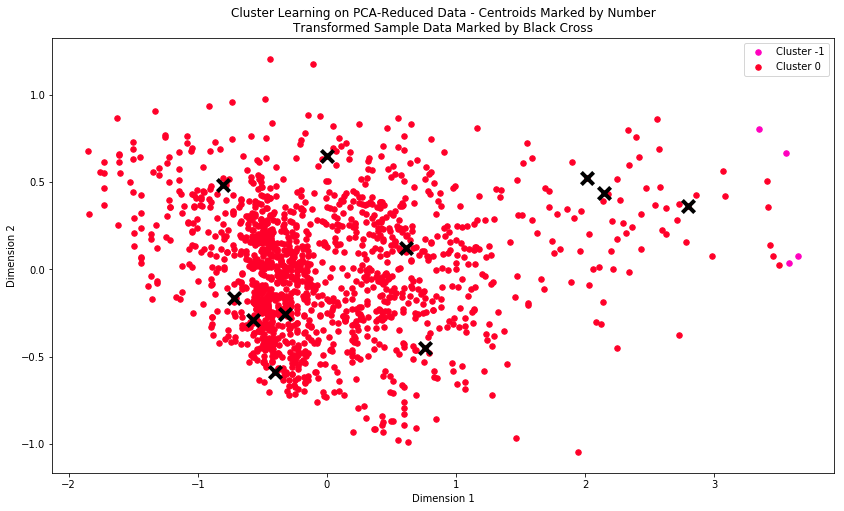

In [25]:
# Maximizing silhouette score
dbscan_1 = DBSCAN(eps=0.9, min_samples=60)
dbscan_1.fit(reduced_data)
db_1_labels = dbscan_1.labels_

vs.cluster_results(reduced_data, db_1_labels, [], pca_samples)
print('Silhouette Score: {} \nCalinski-Harabaz Score: {}'.format(metrics.silhouette_score(reduced_data, db_1_labels, random_state=42),
metrics.calinski_harabaz_score(reduced_data, db_1_labels)))

Silhouette Score: 0.633710848760006 
Calinski-Harabaz Score: 741.0069772424026


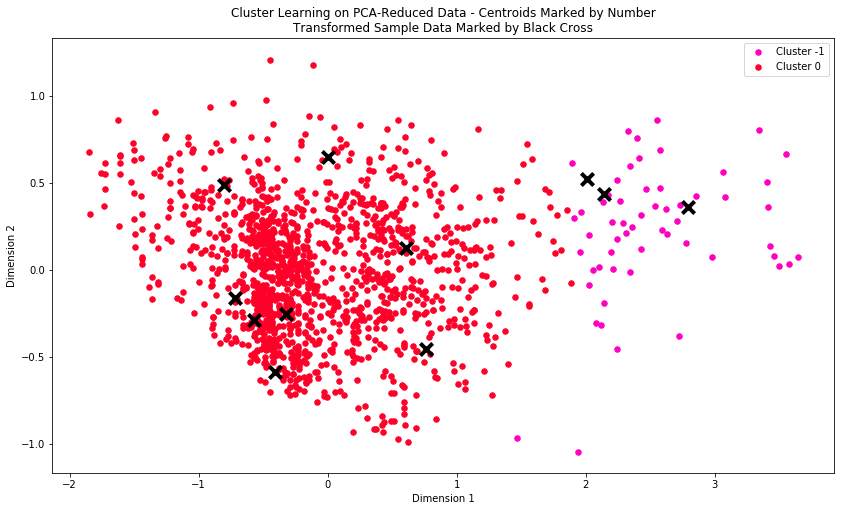

In [27]:
dbscan_2 = DBSCAN(eps=0.5, min_samples=60)
dbscan_2.fit(reduced_data)
db_2_labels = dbscan_2.labels_

vs.cluster_results(reduced_data, db_2_labels, [], pca_samples)
print('Silhouette Score: {} \nCalinski-Harabaz Score: {}'.format(metrics.silhouette_score(reduced_data, db_2_labels, random_state=42),
metrics.calinski_harabaz_score(reduced_data, db_2_labels)))

Silhouette Score: 0.3835391502773278 
Calinski-Harabaz Score: 1580.7779934810658


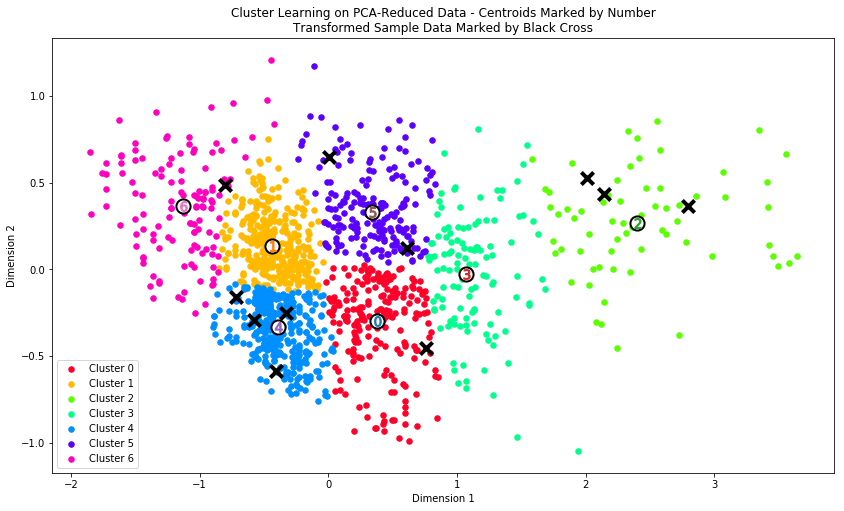

In [28]:
gm = GaussianMixture(n_components=7, covariance_type='full', tol=0.1, max_iter=50, init_params='kmeans', random_state=42)

clusterer = gm.fit(reduced_data)

gm_preds = clusterer.predict(reduced_data)

gm_centers = clusterer.means_

vs.cluster_results(reduced_data, gm_preds, gm_centers, pca_samples)

print('Silhouette Score: {} \nCalinski-Harabaz Score: {}'.format(metrics.silhouette_score(reduced_data, gm_preds, random_state=42),
metrics.calinski_harabaz_score(reduced_data, gm_preds)))

Silhouette Score: 0.3855447311262053 
Calinski-Harabaz Score: 1615.551546526856


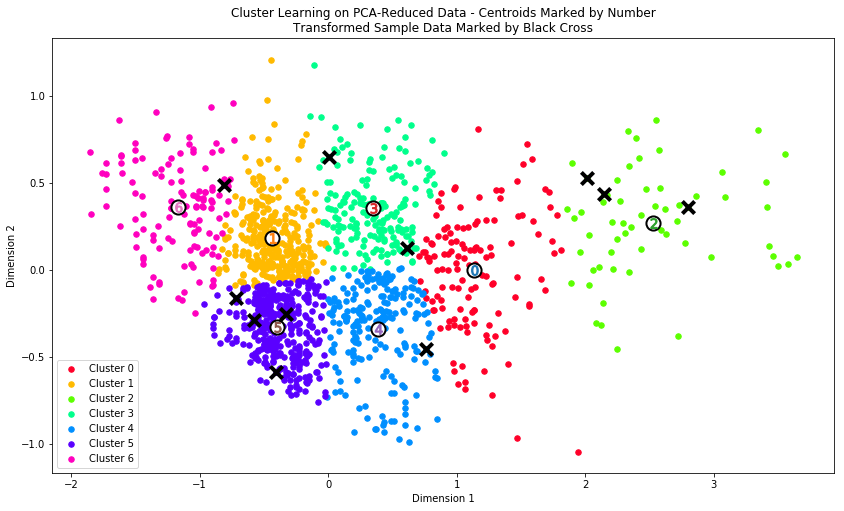

In [29]:
km = KMeans(n_clusters=7)

km_clusterer = km.fit(reduced_data)

km_preds = km_clusterer.predict(reduced_data)

km_centers = km_clusterer.cluster_centers_

vs.cluster_results(reduced_data, km_preds, km_centers, pca_samples)

print('Silhouette Score: {} \nCalinski-Harabaz Score: {}'.format(metrics.silhouette_score(reduced_data, km_preds, random_state=42),
metrics.calinski_harabaz_score(reduced_data, km_preds)))

### Data Recovery
Each cluster present in the visualizations for K-means and GMM above has a central point. These centers (or means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to the average customer of that segment. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.


In [30]:
# GMM centers
log_centers = pca.inverse_transform(gm_centers)

true_centers = np.exp(log_centers)

segments = ['Segment {}'.format(i) for i in range(0,len(gm_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,age,period_total_quantity,period_total_value
Segment 0,47.0,2.0,34933.0
Segment 1,33.0,1.0,15870.0
Segment 2,30.0,7.0,139794.0
Segment 3,38.0,3.0,54620.0
Segment 4,48.0,1.0,19381.0
Segment 5,28.0,2.0,27200.0
Segment 6,27.0,1.0,8529.0


In [31]:
# K-means centers
log_centers = pca.inverse_transform(km_centers)

true_centers = np.exp(log_centers)

segments = ['Segment {}'.format(i) for i in range(0,len(km_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,age,period_total_quantity,period_total_value
Segment 0,37.0,3.0,57062.0
Segment 1,31.0,1.0,15647.0
Segment 2,30.0,8.0,153533.0
Segment 3,27.0,2.0,27171.0
Segment 4,49.0,2.0,35632.0
Segment 5,48.0,1.0,19299.0
Segment 6,27.0,1.0,8309.0


## Conclusion

After all, the k-means was the best algorithm to cluster the data. With a Silhouette Score of 0.3858329089846184 and a Calinski-Harabaz Score of 1615.5499935839932. It is better than the Gaussian Mixture Model and much better than the DBSCAN model, wich did not prove useful for the dataset at hand. Although I thought it would be better to use GMM or DBSCAN than to use the traditional and simple k-means, I am very happy to have compared three algorithms. I am also happy that with this segmentation, the company will be able to keep searching for more insights from their customers and give a better service and better products.